In [2]:
#load simulation data with loadSimDataOneHot
from simDataPreprocessing import loadSimDataOneHot

data, labels = loadSimDataOneHot('/mnt/d/data/MIME_data/simData/dmMIME/seqLen100/experimentalConditions', maxNumSequences=100000, splittingProbability=3/100, readSize=23)

first round prot1 done
first round prot6 done
first round prot15 done
first round prot 30 done


In [3]:
data.shape, labels.shape

((1521782, 402), (1521782, 1))

In [4]:
#split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1369603, 402), (152179, 402), (1369603, 1), (152179, 1))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [7]:
#load data into torch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [8]:
#load data into torch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [52]:
#set model parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10
lambda_l2 = 0.001
size_factor_hidden = 10
bottle_neck_factor = 1/size_factor_hidden

In [53]:
#load data into torch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [54]:
#set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [55]:
#set input and output dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [56]:
#define 4 layer neural network with relu activation function and sigmoid output
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #first layer with input_dim input neurons and inputdim*size_factor_hidden output neurons
        self.fc1 = nn.Linear(input_dim, input_dim*size_factor_hidden)
        #second layer with inputdim*size_factor_hidden input neurons and inputdim*size_factor_hidden output neurons
        self.fc2 = nn.Linear(input_dim*size_factor_hidden, input_dim*size_factor_hidden)
        #third layer with inputdim*size_factor_hidden input neurons and inputdim output neurons
        self.fc3 = nn.Linear(input_dim*size_factor_hidden, int(input_dim*size_factor_hidden*bottle_neck_factor))
        #fourth layer with inputdim input neurons and output_dim output neurons
        self.fc4 = nn.Linear(int(input_dim*size_factor_hidden*bottle_neck_factor), output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x



In [57]:
#initialize model
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=402, out_features=4020, bias=True)
  (fc2): Linear(in_features=4020, out_features=4020, bias=True)
  (fc3): Linear(in_features=4020, out_features=402, bias=True)
  (fc4): Linear(in_features=402, out_features=1, bias=True)
)

In [58]:
#set loss function and adam optimizer with l2 regularization
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [59]:
#import tqdm notebook for progress bar
from tqdm import tqdm

In [60]:
#train model on gpu and track training and test loss
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    train_loss = 0
    test_loss = 0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))
    model.eval()
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
    test_losses.append(test_loss/len(test_loader))

Epoch 1/10


100%|██████████| 2378/2378 [00:02<00:00, 1074.24it/s]


Epoch 2/10


100%|██████████| 2378/2378 [00:02<00:00, 1029.11it/s]


Epoch 3/10


100%|██████████| 2378/2378 [00:02<00:00, 1053.32it/s]


Epoch 4/10


100%|██████████| 2378/2378 [00:02<00:00, 1177.23it/s]


Epoch 5/10


100%|██████████| 2378/2378 [00:02<00:00, 1122.92it/s]


Epoch 6/10


100%|██████████| 2378/2378 [00:02<00:00, 1114.15it/s]


Epoch 7/10


100%|██████████| 2378/2378 [00:02<00:00, 1112.03it/s]


Epoch 8/10


100%|██████████| 2378/2378 [00:02<00:00, 1139.72it/s]


Epoch 9/10


100%|██████████| 2378/2378 [00:02<00:00, 1004.17it/s]


Epoch 10/10


100%|██████████| 2378/2378 [00:02<00:00, 1059.26it/s]


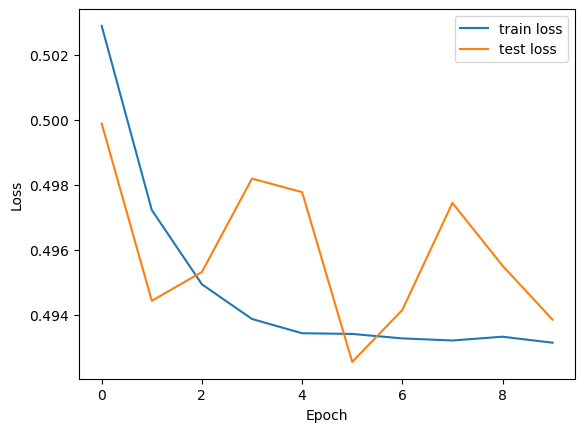

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot training and test loss
sns.lineplot(x=range(num_epochs), y=train_losses, label='train loss')
sns.lineplot(x=range(num_epochs), y=test_losses, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [62]:
#get error on training and test set
def getError(model, loader):
    error = 0
    model.eval()
    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        error += torch.sum(torch.abs(torch.round(output) - target)).item()
    return error/len(loader.dataset)

train_error = getError(model, train_loader)
test_error = getError(model, test_loader)
print('Training error: {}'.format(train_error))
print('Test error: {}'.format(test_error))

100%|██████████| 2378/2378 [00:02<00:00, 1041.23it/s]

Training error: 0.2212655784194398
Test error: 0.22158116428679384


# first checks
bottlenecking the last 2 layers is fine

size_factor_hidden 10/20 no diff

data amount with 50000 results in low variance 

unavoidable error for samples that end up 50/50 in bound/unbound

-> change loss and label to frquencies in pools

In [68]:
import numpy as np

# read in kd values
kds = np.loadtxt('/mnt/d/data/MIME_data/simData/dmMIME/seqLen100/experimentalConditions/secondFromProt1/prot1/single_kds.txt')

#insert 1 at position 0 and then every 3rd position
kds = np.insert(kds, 0, 1)
kds = np.insert(kds, np.arange(4, len(kds), 3), 1)
kds[0:10]

array([1.      , 0.212905, 0.362492, 1.      , 1.      , 0.393369,
       3.48016 , 1.      , 1.      , 1.      ])

In [82]:
#save inferred probabilities for all protein concentration combinations

#initialize dictionary to store inferred probabilities
inferred_probs = {}

proteinConcentrations = [1,6,15,30]

#loop over protein concentrations
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        #create prediction example for current protein concentration combination and zeros for all kd values
        prediction_example = np.zeros((1, len(kds)))
        #insert protein concentration values at position 1 and 2
        prediction_example = np.insert(prediction_example, 0, protConc1)
        prediction_example = np.insert(prediction_example, 1, protConc2)
        
        #loop to set each position to 1 and infer probability
        predictions = []
        for i in range(2, len(kds)+2):
            current_prediction_example = prediction_example.copy()
            current_prediction_example[i] = 1
            current_prediction_example = torch.from_numpy(current_prediction_example).float()
            current_prediction_example = current_prediction_example.to(device)
            #output binding probability and append list for given protein concentration combination
            with torch.no_grad():
                output = model(current_prediction_example)
                predictions.append(output.item())
        #save inferred probabilities for given protein concentration combination
        inferred_probs[(protConc1, protConc2)] = predictions
            

In [84]:
#get variance of inferred probabilities for each protein concentration combination
variances = []
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        variances.append(np.var(inferred_probs[(protConc1, protConc2)]))

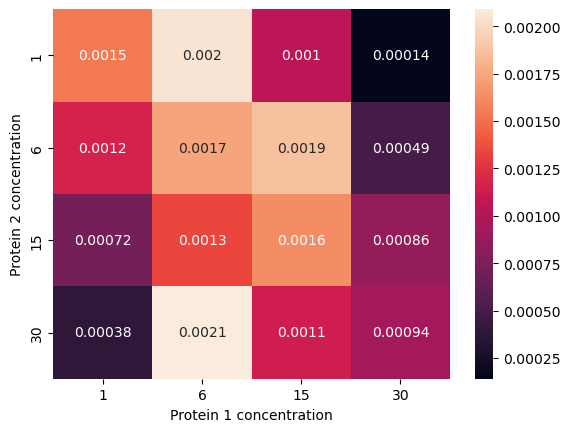

In [86]:
#plot variance of inferred probabilities for each protein concentration combination
sns.heatmap(np.array(variances).reshape(4,4), annot=True, xticklabels=proteinConcentrations, yticklabels=proteinConcentrations)
plt.xlabel('Protein 1 concentration')
plt.ylabel('Protein 2 concentration')
plt.show()

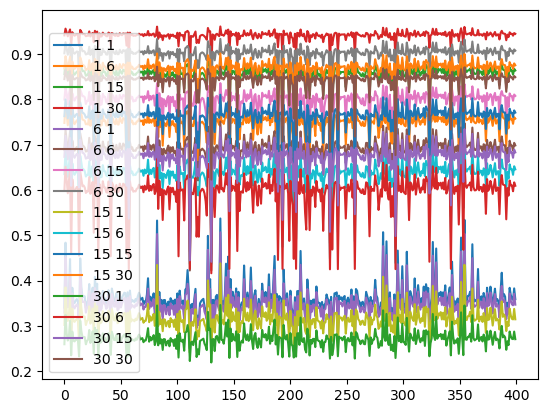

In [88]:
#plot inferred probabilities for each protein concentration combination
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        sns.lineplot(x=range(len(inferred_probs[(protConc1, protConc2)])), y=inferred_probs[(protConc1, protConc2)], label='{} {}'.format(protConc1, protConc2))

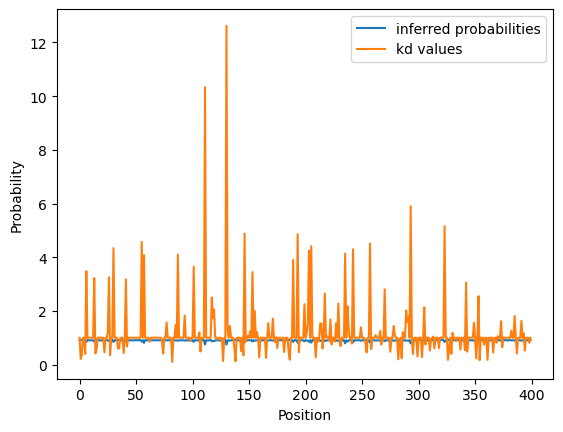

In [102]:
#plot predictions of highest variance protein concentration combination vs kd values
sns.lineplot(x=range(len(inferred_probs[(6,30)])), y=inferred_probs[(6,30)], label='inferred probabilities')
sns.lineplot(x=range(len(kds)), y=kds, label='kd values')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.show()

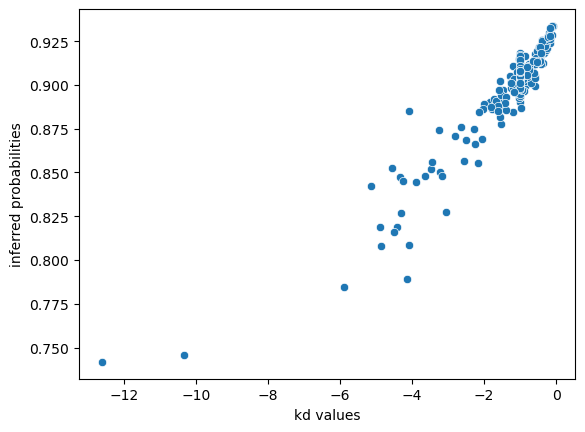

In [107]:
#scatter plot of inferred probabilities vs kd values
sns.scatterplot(x=-kds, y=inferred_probs[(6,30)])
plt.xlabel('kd values')
plt.ylabel('inferred probabilities')
plt.show()

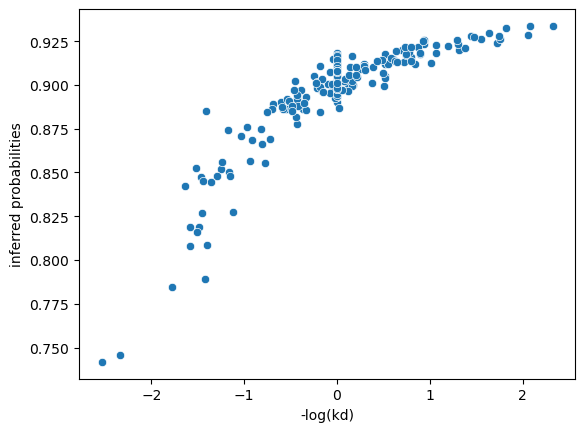

In [106]:
#scatterplot of negative log of kd values vs inferred probabilities
sns.scatterplot(x=-np.log(kds), y=inferred_probs[(6,30)])
plt.xlabel('-log(kd)')
plt.ylabel('inferred probabilities')
plt.show()